<a href="https://colab.research.google.com/github/krajak09/Master-Thesis/blob/main/scripts/Train_and_Test_on_RandomWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%pip install filterpy

Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [26]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import os
import scipy.optimize as opt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from filterpy.kalman import KalmanFilter

In [27]:
# This will print out the downloaded path
path = kagglehub.dataset_download("angelvarela/gold-data-to-predict-the-stock-market")
print("Downloaded files:", path)

print(os.listdir(path))  # List all files in the dataset folder

Downloaded files: /Users/keerthi/.cache/kagglehub/datasets/angelvarela/gold-data-to-predict-the-stock-market/versions/2
['Achilles_Data-Gold.csv', 'Achilles_Data-Gold-Silver.csv']


In [ ]:
# Set the path to the file you'd like to load
file_path = "Achilles_Data-Gold.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "angelvarela/gold-data-to-predict-the-stock-market",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)
# convert UNIX timestamp to datetime
df['time'] = pd.to_datetime(df['time'], unit = 's')

# sort by time and set as index
df = df.sort_values('time')

In [29]:
df["timestep"] = range(len(df))
df.head()

,time,open,high,low,close,tick_volume,ema,obv,timestep
0,2023-01-03 01:02:00,1826.92,1827.65,1826.92,1827.24,47,2166.827022,47.0,0
1,2023-01-03 01:03:00,1827.26,1827.86,1827.18,1827.84,36,2166.827022,83.0,1
2,2023-01-03 01:04:00,1827.83,1828.70,1827.83,1828.66,47,2166.827022,130.0,2
3,2023-01-03 01:05:00,1828.65,1829.92,1828.62,1829.80,65,2166.827022,195.0,3
4,2023-01-03 01:06:00,1829.84,1830.94,1829.84,1830.63,87,2166.827022,282.0,4


In [30]:
csv_path = os.path.join(path, "Achilles_Data-Gold.csv")

df_train = pd.read_csv(csv_path)
print(df_train.head())

         time     open     high      low    close  tick_volume          ema  \
0  1672707720  1826.92  1827.65  1826.92  1827.24           47  2166.827022   
1  1672707780  1827.26  1827.86  1827.18  1827.84           36  2166.827022   
2  1672707840  1827.83  1828.70  1827.83  1828.66           47  2166.827022   
3  1672707900  1828.65  1829.92  1828.62  1829.80           65  2166.827022   
4  1672707960  1829.84  1830.94  1829.84  1830.63           87  2166.827022   

     obv  
0   47.0  
1   83.0  
2  130.0  
3  195.0  
4  282.0  


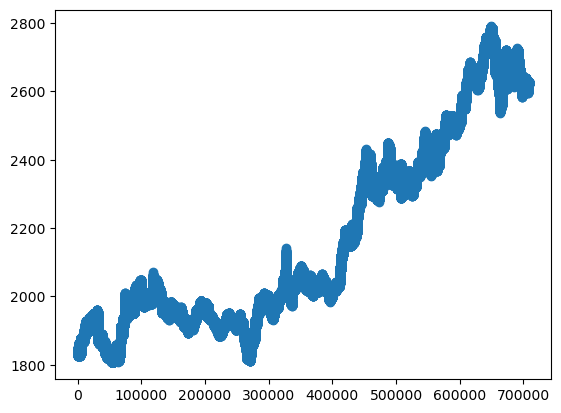

In [31]:
# df.index row label of data frame
plt.scatter(df.index, df['open'])

In [32]:
x = df.index.values.reshape(-1, 1) # Reshape x to be a 2D array
y = df['open'].values # x = index, y = price

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [33]:
def filter_random_walk(y, sigma2_q, sigma2_r, x0, P0):
  f = KalmanFilter (dim_x=1, dim_z=1)

  f.x = np.array([[x0]])

  f.F = np.array([[1.0]])
  f.H = np.array([[1.0]])

  # Initial covariance
  f.P = np.array([[P0]])

  # Process Noise
  f.Q = np.array([[sigma2_q]])
  f.R = np.array([[sigma2_r]])

  filtered_state = []
  filtered_obs = []

  for z in y:
    f.predict()
    f.update(float(z))
    filtered_state.append(f.x)
    filtered_obs.append(float(f.measurement_of_state(f.x)))

  return filtered_state, filtered_obs

In [34]:
def predict_random_walk(y, sigma2_q, sigma2_r, x0, P0):
  f = KalmanFilter (dim_x=1, dim_z=1)

  f.x = np.array([[x0]])

  f.F = np.array([[1.0]])
  f.H = np.array([[1.0]])

  # Initial covariance
  f.P = np.array([[P0]])

  # Process Noise
  f.Q = np.array([[sigma2_q]])
  f.R = np.array([[sigma2_r]])

  mse_total = 0.0
  error_list = []

  for z in y:
    f.predict()
    y_pred = float(f.measurement_of_state(f.x))
    z = float(z)
    mse = (y_pred - z)**2

    error_list.append(mse)
    mse_total += mse

    f.update(z)
  return mse_total, error_list

In [35]:
def make_energy_random_walk(y, x0, P0):

  def energy_fun(theta):
    log_sigma2_q = theta[0]
    log_sigma2_r = theta[1]
    sigma2_q = np.exp(log_sigma2_q) #sigma needs to be non-negative
    sigma2_r = np.exp(log_sigma2_r) #sigma needs to be non-negative

    f = KalmanFilter (dim_x=1, dim_z=1)

    f.x = np.array([[x0]])

    f.F = np.array([[1.0]])
    f.H = np.array([[1.0]])

    # Initial covariance
    f.P = np.array([[P0]])

    # Process Noise
    f.Q = np.array([[sigma2_q]])
    f.R = np.array([[sigma2_r]])

    score = 0.0

    for z in y:
      f.predict()
      f.update(z)
      score += f.log_likelihood
    return -score

  return energy_fun

In [38]:
def fit_and_predict_random_walk(y, x0, P0):
  # Fit maximum likelihood
  energy_fun = make_energy_random_walk(y, x0=x0, P0=P0) # Use provided x0 and P0
  theta0 = np.array([np.log(1.0),np.log(1.0)]) # Correct initial guess for log_sigma2_q and log_sigma2_r
  res = opt.minimize(energy_fun, theta0)

  # Compute MSE for fitted model
  log_sigma2_q = res.x[0]
  log_sigma2_r = res.x[1]
  sigma2_q = np.exp(log_sigma2_q)
  sigma2_r = np.exp(log_sigma2_r)

  mse, error_list = predict_random_walk(y, sigma2_q, sigma2_r, x0, P0)
  filtered_states, filtered_obs = filter_random_walk(y, sigma2_q, sigma2_r, x0, P0)

  return res, mse, error_list, filtered_states, filtered_obs

In [ ]:
# Define initial values for x0 and P0
initial_price = y[0] # Use the first observed price as initial state estimate
initial_uncertainty = 1.0 # Initial uncertainty in the state

# Use only the first 1000 rows for faster execution
y_subset = y[:1000]

res, mse, error_list, filtered_states, filtered_obs = fit_and_predict_random_walk(y_subset, initial_price, initial_uncertainty)

In [ ]:
# Extract fitted noise variances
sigma2_q = np.exp(res.x[0])
sigma2_r = np.exp(res.x[1])

# Fit on training data
res, mse, error_list, filtered_states_train, _ = fit_and_predict_random_walk(
    y_train, x0=y_train[0], P0=1.0
)
filtered_states_train = np.array(filtered_states_train, dtype=float).ravel()

# Predict on test data (1-step ahead)
last_state = filtered_states_train[-1]
P_last = 1.0
filt_test, _ = filter_random_walk(y_test, sigma2_q, sigma2_r, last_state, P_last)
filt_test = np.array(filt_test, dtype=float).ravel()


# Plot
plt.plot(x, y, color="orange", label="observations")
# draws vertical line at x-coordinate x_train[-1]
plt.axvline(x_train[-1], color="orange", linestyle="--", label="train/test split")
plt.plot(x_train, filtered_states_train, color="deepskyblue", label="filtered state (train)")
plt.plot(x_test, filt_test, color="teal", label="1-step preds (test)")
plt.title("Random Walk Kalman Filter — Train/Test")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()